In [118]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import numpy as np 
import random 
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn as sns
import matplotlib.pyplot as plt
import re

def make_aesthetic(hex_color_list=None, with_gridlines=True, bold_title=False, save_transparent=True, font_scale=2):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not:
    # plt.title(r$'\bf{bolded title}$\nAnd a non-bold subtitle')
    
    sns.set(style='white', context='paper', font_scale=font_scale)


    # Write hex color list
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#D41876", # Telemagenta
        "#00A896", # Persian green,
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    try:
        plt.rcParams['font.family'] = 'Arial'
    except:
        pass
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    if bold_title:
        plt.rcParams['axes.titleweight'] = 'bold'
    else:
        plt.rcParams['axes.titleweight'] = 'regular'
    plt.rcParams['axes.grid'] = with_gridlines
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = save_transparent
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.titlepad'] = 20*(font_scale/1)
    return hex_color_list
mypal =make_aesthetic()


def bootstrap_cor(x, y, method='spearman', iters=10000, alpha=0.95, random_seed=416, round_digits=2, show_progress=True):
    """
    Bootstrap CIs for correlation coefficients using Scipy.
    """
    np.random.seed(random_seed)
    
    x = np.array(x)
    y = np.array(y)

    if np.std(x) == 0 or np.std(y) == 0:
        raise ValueError("Error: no variability in either x or y... check your data")

    n = len(x)
    correlation_estimates = []

    correlation_func = {
        'spearman': spearmanr,
        'pearson': pearsonr,
        'pointbiserial': pointbiserialr,
        'kendall': kendalltau
    }.get(method, None)
    if correlation_func is None:
        raise ValueError("Method should be 'spearman', 'pearson', 'pointbiserial', or 'kendall'")

    observed, _ = correlation_func(x, y)

    # Bootstrap
    for _ in tqdm(range(iters), disable=not show_progress):
        indices = np.random.choice(n, size=n, replace=True)
        sample_x, sample_y = x[indices], y[indices]
        correlation, _ = correlation_func(sample_x, sample_y)
        if not np.isnan(correlation):
            correlation_estimates.append(correlation)

    if not correlation_estimates:
        raise ValueError("All tries resulted in NaNs")

    # CIs
    lower = np.percentile(correlation_estimates, (1 - alpha) / 2 * 100)
    upper = np.percentile(correlation_estimates, (1 + alpha) / 2 * 100)
    sig = 1 - int(lower <= 0 <= upper)


    # Return data
    data = {'obs': observed, 'lower': lower, 'upper': upper, 'sig': sig}
    if round_digits is not None:
        for key in ['obs', 'lower', 'upper']:
            data[f"round_{key}"] = np.round(data[key], round_digits)
    return data



# Data reading and features

In [170]:
df = pd.read_csv("NPDB2310.CSV")
df.columns = df.columns.str.lower()
df = df.query("outcome<10") # Outcome 10 means not available
df['severity'] = df['outcome'].astype(int)
df['years'] = df['origyear'] - df['malyear1']
df = df.dropna(subset=['malyear1', 'origyear', 'outcome', 'years', 'severity'])

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/3663788841.py:1: DtypeWarning: Columns (18,19,20,22,23,25,26,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NPDB2310.CSV")


# Descriptive Statistics

In [171]:
print(len(df))

display(df.describe())

252530


,seqno,reptype,origyear,workctry,homectry,licnfeld,practage,grad,algnnatr,alegatn1,...,nplicrpt,npclprpt,nppsmrpt,npdearpt,npexcrpt,npgarpt,npctmrpt,fundpymt,severity,years
count,2.525300e+05,252530.000000,252530.000000,0.0,0.0,252530.000000,251908.000000,252529.000000,252530.000000,252530.000000,...,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000,252530.000000
mean,1.255128e+06,101.186014,2012.730309,NaN,NaN,52.165533,45.002223,1981.811040,32.493066,258.895038,...,0.411816,0.087154,0.005203,0.013923,0.065180,0.003279,0.000313,0.045432,6.010268,4.704035
std,5.147992e+05,0.389118,5.792389,NaN,NaN,129.510744,11.457739,13.305367,26.717973,164.908149,...,1.309120,0.482059,0.090344,0.131232,0.456344,0.065557,0.018127,0.208251,2.392871,2.972948
min,5.144560e+05,101.000000,2004.000000,NaN,NaN,10.000000,10.000000,1910.000000,1.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.488712e+05,101.000000,2008.000000,NaN,NaN,10.000000,40.000000,1970.000000,1.000000,108.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000
50%,1.245085e+06,101.000000,2012.000000,NaN,NaN,10.000000,40.000000,1980.000000,20.000000,305.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000
75%,1.709670e+06,101.000000,2018.000000,NaN,NaN,20.000000,50.000000,1990.000000,60.000000,308.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,6.000000
max,2.155320e+06,102.000000,2023.000000,NaN,NaN,699.000000,80.000000,2020.000000,100.000000,999.000000,...,79.000000,22.000000,5.000000,13.000000,14.000000,3.000000,2.000000,1.000000,9.000000,107.000000


# Bootstrap zero-order correlation 

In [229]:
res = bootstrap_cor(df['severity'], df['log_years'], iters=5000)
#res = {'obs': 0.17640945915088305, 'lower': 0.17248973095476552, 'upper': 0.1803060624980964, 'sig': 1, 'round_obs': 0.18, 'round_lower': 0.17, 'round_upper': 0.18}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:32<00:00, 32.85it/s]


# Bivariate plot

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/346415797.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=df, x='severity', y='years', estimator='mean', join=False, color=mypal[1], alpha=1)


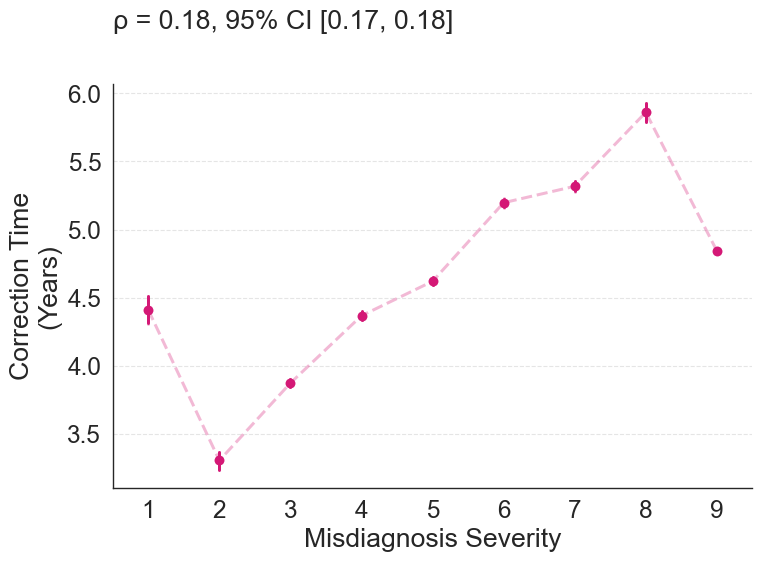

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/346415797.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, y='years', x='severity', palette='mako_r')


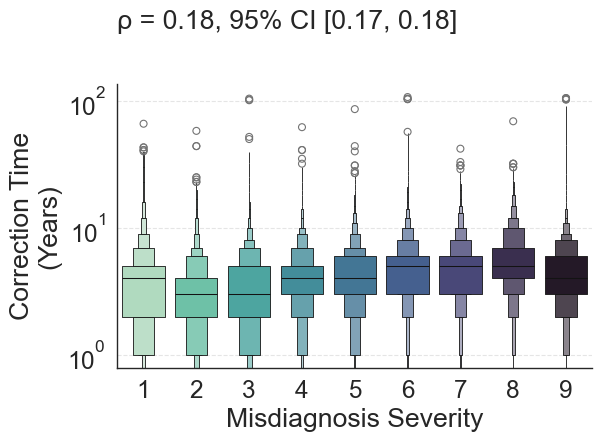

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
# First, plot the lines in the desired color
sns.pointplot(data=df, x='severity', y='years', estimator='mean', color=mypal[1], alpha=0.3, linestyle='dashed')
sns.pointplot(data=df, x='severity', y='years', estimator='mean', join=False, color=mypal[1], alpha=1)


plt.title(f"ρ = {res['round_obs']}, 95% CI [{res['round_lower']}, {res['round_upper']}]")
plt.ylabel("Correction Time\n(Years)")
plt.xlabel("Misdiagnosis Severity")
plt.savefig("line_diag.png", dpi=400, transparent=False)
plt.show()

sns.boxenplot(data=df, y='years', x='severity', palette='mako_r')
plt.title(f"ρ = {res['round_obs']}, 95% CI [{res['round_lower']}, {res['round_upper']}]")
plt.ylabel("Correction Time\n(Years)")
plt.xlabel("Misdiagnosis Severity")
plt.yscale('log')
plt.savefig("boxen_diagnosis.png", dpi=400, transparent=False)

# Model

In [226]:
import statsmodels.formula.api as smf
df['log_years'] = np.log(df['years']+1)
mod = smf.ols(formula='years ~ severity + numbprsn + C(paynumbr) + ptgender + ptage + C(licnstat) + practage', data=df).fit()

display(mod.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  years   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     677.9
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:08:38   Log-Likelihood:            -5.5187e+05
No. Observations:              231630   AIC:                         1.104e+06
Df Residuals:                  231566   BIC:                         1.105e+06
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.0368      0.143     35.251      0.000       4.757       5.317
C(paynumbr)[T.S]     -0.3610      0.027    -13.356      0.000      -0.414      -0.308
ptgender[T.M]         0.1083      0.011      9.742      0.000       0.087       0.130
ptgender[T.U]        -0.0298      0.135     -0.220      0.826      -0.295       0.235
C(licnstat)[T.AL]    -0.0602      0.156     -0.387      0.699      -0.365       0.245
C(licnstat)[T.AR]    -0.2476      0.157     -1.579      0.114      -0.555       0.060
C(licnstat)[T.AZ]    -0.3345      0.144     -2.327      0.020      -0.616      -0.053
C(licnstat)[T.CA]    -0.8999      0.139     -6.479      0.000      -1.172      -0.628
C(licnstat)[T.CO]    -0.9338      0.148     -6.329      0.000      -1.223      -0.645
C(licnstat)[T.CT]     0.9586      0.146      6.558      0.000       0.672       1.245
C(licnstat)[T.DC]     0.2614      0.179      1.459      0.144      -0.090       0.612
C(licnstat)[T.DE]    -0.1213      0.180     -0.675      0.500      -0.473       0.231
C(licnstat)[T.FL]    -0.4867      0.139     -3.497      0.000      -0.759      -0.214
C(licnstat)[T.FM]    -0.2657      1.859     -0.143      0.886      -3.909       3.378
C(licnstat)[T.GA]    -0.2870      0.143     -2.014      0.044      -0.566      -0.008
C(licnstat)[T.GU]    -0.1839      0.885     -0.208      0.835      -1.918       1.550
C(licnstat)[T.HI]     0.2372      0.173      1.369      0.171      -0.102       0.577
C(licnstat)[T.IA]    -0.6656      0.152     -4.365      0.000      -0.964      -0.367
C(licnstat)[T.ID]    -0.6511      0.172     -3.780      0.000      -0.989      -0.313
C(licnstat)[T.IL]     1.3890      0.141      9.868      0.000       1.113       1.665
C(licnstat)[T.IN]     1.7839      0.143     12.491      0.000       1.504       2.064
C(licnstat)[T.KS]    -0.5828      0.146     -4.002      0.000      -0.868      -0.297
C(licnstat)[T.KY]     0.1431      0.147      0.976      0.329      -0.144       0.430
C(licnstat)[T.LA]     1.6184      0.142     11.416      0.000       1.341       1.896
C(licnstat)[T.MA]     1.5819      0.142     11.150      0.000       1.304       1.860
C(licnstat)[T.MD]     0.0166      0.143      0.116      0.908      -0.263       0.296
C(licnstat)[T.ME]     0.0552      0.166      0.334      0.739      -0.269       0.380
C(licnstat)[T.MI]     0.0295      0.141      0.209      0.834      -0.247       0.306
C(licnstat)[T.MN]    -0.5392      0.155     -3.480      0.001      -0.843      -0.236
C(licnstat)[T.MO]     0.0253      0.144      0.175      0.861      -0.258       0.308
C(licnstat)[T.MP]     1.0638      1.520      0.700      0.484      -1.915       4.043
C(licnstat)[T.MS]     0.5696      0.153      3.731      0.000       0.270       0.869
C(licnstat)[T.MT]    -0.2435      0.165     -1.480      0.139      -0.566

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/213682987.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sum_res = pd.read_html(mod.summary().tables[1].as_html(),header=0,index_col=0)[0].reset_index()
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/213682987.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(y='clean_var', x='coef', data=df_sub, capsize=0.1, join=False, palette=df_sub['color'].tolist())
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_3565/213682987.py:49: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y='clean_var', x='coef', data=d

Beta = 0.13 [SE = 0.0, 95% CI = (0.13, 0.14)], p = 0.0


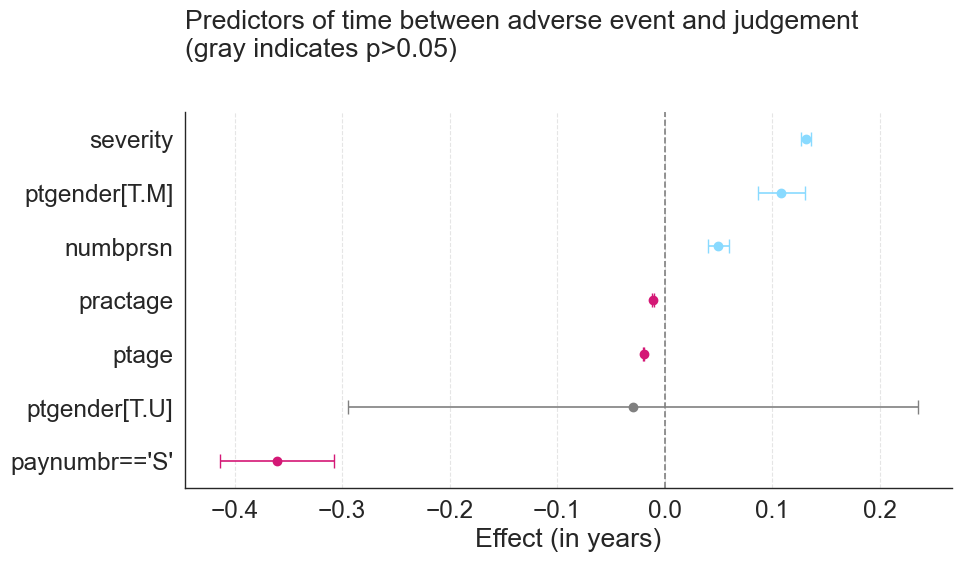

In [224]:
def clean_statsmodels_name(var_name):
    """
    If a name is like C(Race)[T.Other] then it returns Race==Other, 
    else returns normal name. 

    """
    # regex expression to match the pattern 'C(Race)[T.Other]'
    pattern = r'C\((.*?)\)\[T\.(.*?)\]'
    match = re.match(pattern, var_name)

    if match:
        factor, value = match.groups()
        cleaned_name = f"{factor}=='{value}'"
    else:
        # If the pattern does not match, return the original variable name
        cleaned_name = var_name

    return cleaned_name

def filter_vars(all_vars, sub_str):
    matched_vars = set()
    for var in all_vars:
        if any(sub in var for sub in sub_str):
            matched_vars.add(var)

    return list(matched_vars)


sum_res = pd.read_html(mod.summary().tables[1].as_html(),header=0,index_col=0)[0].reset_index()
sum_res = sum_res.rename(columns={'index':'var'})

#################
# Plot of reg coefs
#################
make_aesthetic(with_gridlines=True)

good_vars = [x for x in sum_res['var'] if "licnstat" not in x and x != 'Intercept']
df_sub = sum_res.query("var in @good_vars").sort_values(by=['coef'], ascending=False)

df_sub['clean_var'] = df_sub['var'].apply(clean_statsmodels_name)
df_sub['error_lower'] = df_sub['coef'] - df_sub['[0.025']
df_sub['error_upper'] = df_sub['0.975]'] - df_sub['coef']
errors = df_sub[['error_lower', 'error_upper']].T.values
df_sub['color'] = df_sub.apply(lambda row: mypal[3] if (row['P>|t|'] < 0.05 and row['coef'] > 0) else (mypal[1] if (row['P>|t|'] < 0.05 and row['coef'] < 0) else 'gray'), axis=1)

plt.figure(figsize=(10,6))
for index, row in df_sub.iterrows():
    plt.errorbar(row['coef'], row['clean_var'], xerr=[[row['error_lower']], [row['error_upper']]], fmt='o', capsize=5, color=row['color'])
sns.pointplot(y='clean_var', x='coef', data=df_sub, capsize=0.1, join=False, palette=df_sub['color'].tolist())
plt.ylabel("")
plt.xlabel("Effect (in years)")
plt.title("Predictors of time between adverse event and judgement\n(gray indicates p>0.05)", fontweight='regular')
plt.axvline(x=0, color='gray', linestyle='dashed')
plt.savefig("diagnosis_mod.png", dpi=400)
###############################
# print coef clean to copy paste
###############################
beta = np.round(mod.params['severity'], 2)
se = np.round(mod.bse['severity'], 2)
ci_low = np.round(mod.conf_int().loc['severity', 0], 2)
ci_high = np.round(mod.conf_int().loc['severity', 1], 2)
f = f"Beta = {beta} [SE = {se}, 95% CI = ({ci_low}, {ci_high})], p = {mod.pvalues['severity']}"
print(f)

